https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [2]:
X.shape

(6, 3)

## LSTM
[samples, timesteps, features]

In [4]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.36691]]


In [5]:
# define model   Stacked LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [6]:
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.32918]]


In [14]:
# define model Bidirectional
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [8]:
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.726135]]


## CNN-LSTM.
[samples, subsequences, timesteps, features]
https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

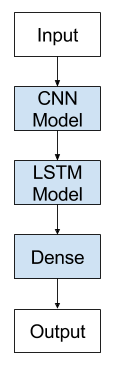

In [9]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
X

array([[10, 20, 30, 40],
       [20, 30, 40, 50],
       [30, 40, 50, 60],
       [40, 50, 60, 70],
       [50, 60, 70, 80]])

In [6]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
X.shape

ValueError: cannot reshape array of size 18 into shape (6,2,2,1)

In [4]:
x_input = array([60, 70, 80, 90])
x_input

array([60, 70, 80, 90])

In [7]:
n_features = 1
n_seq = 2
n_steps = 2
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
x_input

array([[[[60],
         [70]],

        [[80],
         [90]]]])

In [8]:
x_input.shape

(1, 2, 2, 1)

In [15]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model  CNN-LSTM.
# wrapping the entire CNN input model (one layer or more) in a TimeDistributed layer.
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________
[[102.79331]]


## ConvLSTM
[samples, timesteps, rows, columns, features]
convolutional reading of input is built directly into each LSTM unit

In [17]:

# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))


In [18]:
# define model  ConvLSTM
from keras.layers import ConvLSTM2D

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
[[103.682014]]


## Multivariate LSTM Models
there is more than one observation for each time step